In [ ]:
# RNN walk-through

In [300]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
from random import randint

In [270]:
# training dataset generation
int2binary = {}
binary_dim = 8

largest_number = pow(2,binary_dim)
binary = np.unpackbits(
    np.array([range(largest_number)],dtype=np.uint8).T,axis=1)
for i in range(largest_number):
    int2binary[i] = binary[i]

In [281]:
int2binary

{0: array([0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 1: array([0, 0, 0, 0, 0, 0, 0, 1], dtype=uint8),
 2: array([0, 0, 0, 0, 0, 0, 1, 0], dtype=uint8),
 3: array([0, 0, 0, 0, 0, 0, 1, 1], dtype=uint8),
 4: array([0, 0, 0, 0, 0, 1, 0, 0], dtype=uint8),
 5: array([0, 0, 0, 0, 0, 1, 0, 1], dtype=uint8),
 6: array([0, 0, 0, 0, 0, 1, 1, 0], dtype=uint8),
 7: array([0, 0, 0, 0, 0, 1, 1, 1], dtype=uint8),
 8: array([0, 0, 0, 0, 1, 0, 0, 0], dtype=uint8),
 9: array([0, 0, 0, 0, 1, 0, 0, 1], dtype=uint8),
 10: array([0, 0, 0, 0, 1, 0, 1, 0], dtype=uint8),
 11: array([0, 0, 0, 0, 1, 0, 1, 1], dtype=uint8),
 12: array([0, 0, 0, 0, 1, 1, 0, 0], dtype=uint8),
 13: array([0, 0, 0, 0, 1, 1, 0, 1], dtype=uint8),
 14: array([0, 0, 0, 0, 1, 1, 1, 0], dtype=uint8),
 15: array([0, 0, 0, 0, 1, 1, 1, 1], dtype=uint8),
 16: array([0, 0, 0, 1, 0, 0, 0, 0], dtype=uint8),
 17: array([0, 0, 0, 1, 0, 0, 0, 1], dtype=uint8),
 18: array([0, 0, 0, 1, 0, 0, 1, 0], dtype=uint8),
 19: array([0, 0, 0, 1, 0, 0, 1, 1], dtyp

In [322]:
import copy, numpy as np

np.random.seed(randint(0,100))

# compute sigmoid nonlinearity
def sigmoid(x):
    output = 1/(1+np.exp(-x))
    return output

# convert output of sigmoid function to its derivative
def sigmoid_output_to_derivative(output):
    return output*(1-output)


# training dataset generation
int2binary = {}
binary_dim = 8

largest_number = pow(2,binary_dim)
binary = np.unpackbits(
    np.array([range(largest_number)],dtype=np.uint8).T,axis=1)
for i in range(largest_number):
    int2binary[i] = binary[i]


# input variables
alpha = 0.1
input_dim = 2
hidden_dim = 8
output_dim = 1


# initialize neural network weights
synapse_0 = 2*np.random.random((input_dim,hidden_dim)) - 1
synapse_1 = 2*np.random.random((hidden_dim,output_dim)) - 1
synapse_h = 2*np.random.random((hidden_dim,hidden_dim)) - 1

synapse_0_update = np.zeros_like(synapse_0)
synapse_1_update = np.zeros_like(synapse_1)
synapse_h_update = np.zeros_like(synapse_h)

error = []
# training logic
for j in range(10000):
    
    # generate a simple addition problem (a + b = c)
    a_int = np.random.randint(largest_number/2) # int version
    a = int2binary[a_int] # binary encoding

    b_int = np.random.randint(largest_number/2) # int version
    b = int2binary[b_int] # binary encoding

    # true answer
    c_int = a_int + b_int
    c = int2binary[c_int]
    
    # where we'll store our best guess (binary encoded)
    d = np.zeros_like(c)

    overallError = 0
    
    layer_2_deltas = list()
    layer_1_values = list()
    layer_1_values.append(np.zeros(hidden_dim))
    
    # moving along the positions in the binary encoding
    for position in range(binary_dim):
        
        # generate input and output
        X = np.array([[a[binary_dim - position - 1],b[binary_dim - position - 1]]])
        y = np.array([[c[binary_dim - position - 1]]]).T

        # hidden layer (input ~+ prev_hidden)
        layer_1 = sigmoid(np.dot(X,synapse_0) + np.dot(layer_1_values[-1],synapse_h))

        # output layer (new binary representation)
        layer_2 = sigmoid(np.dot(layer_1,synapse_1))

        # did we miss?... if so, by how much?
        layer_2_error = y - layer_2
        layer_2_deltas.append((layer_2_error)*sigmoid_output_to_derivative(layer_2))
        overallError += np.abs(layer_2_error[0])
    
        # decode estimate so we can print it out
        d[binary_dim - position - 1] = np.round(layer_2[0][0])
        
        # store hidden layer so we can use it in the next timestep
        layer_1_values.append(copy.deepcopy(layer_1))
    
    future_layer_1_delta = np.zeros(hidden_dim)
    
    for position in range(binary_dim):
        
        X = np.array([[a[position],b[position]]])
        layer_1 = layer_1_values[-position-1]
        prev_layer_1 = layer_1_values[-position-2]
        
        # error at output layer
        layer_2_delta = layer_2_deltas[-position-1]
        # error at hidden layer
        layer_1_delta = (future_layer_1_delta.dot(synapse_h.T) + layer_2_delta.dot(synapse_1.T)) * sigmoid_output_to_derivative(layer_1)

        # let's update all our weights so we can try again
        synapse_1_update += np.atleast_2d(layer_1).T.dot(layer_2_delta)
        synapse_h_update += np.atleast_2d(prev_layer_1).T.dot(layer_1_delta)
        synapse_0_update += X.T.dot(layer_1_delta)
        
        future_layer_1_delta = layer_1_delta
    

    synapse_0 += synapse_0_update * alpha
    synapse_1 += synapse_1_update * alpha
    synapse_h += synapse_h_update * alpha    

    synapse_0_update *= 0
    synapse_1_update *= 0
    synapse_h_update *= 0
    
    # for plot error
    if(j % 100 == 0):
        error.append(overallError)
    
    # print out progress
    if(j % 2000 == 0):
        print("Epoch:" + str(j+1))
        print("Error:" + str(overallError))
        print("Pred:" + str(d))
        print("True:" + str(c))
        out = 0
        for index,x in enumerate(reversed(d)):
            out += x*pow(2,index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out))
        print("------------")
    
df_36 = pd.DataFrame({'mis36': error })


    

Epoch:1
Error:[4.02317991]
Pred:[1 1 1 1 1 1 1 1]
True:[1 1 0 0 1 1 0 0]
107 + 97 = 255
------------
Epoch:2001
Error:[3.75793791]
Pred:[0 0 0 0 0 1 1 1]
True:[0 1 0 1 0 0 1 1]
67 + 16 = 7
------------
Epoch:4001
Error:[1.85818043]
Pred:[0 1 0 0 1 1 0 0]
True:[0 1 0 0 1 1 0 0]
66 + 10 = 76
------------
Epoch:6001
Error:[1.17826886]
Pred:[0 1 1 1 0 1 0 1]
True:[0 1 1 1 0 1 0 1]
79 + 38 = 117
------------
Epoch:8001
Error:[0.37592401]
Pred:[0 1 0 0 0 0 1 0]
True:[0 1 0 0 0 0 1 0]
34 + 32 = 66
------------


In [ ]:
df_3 = pd.DataFrame({'mis': error })


In [313]:
df_m3 = pd.concat([df_31.reset_index(drop=True), df_32, df_33,df_34,df_35,df_36], axis=1)

In [316]:
df_32 = df_m3.mean(axis=1)

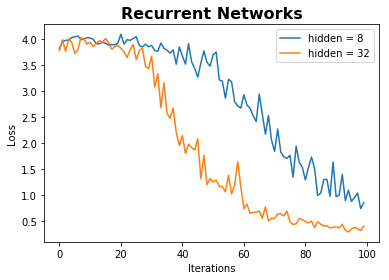

In [317]:
plt.plot(df_8, label = 'hidden = 8')
plt.plot(df_32, label = 'hidden = 32')
#plt.plot(df_13, label = 'hidden = 32')
# Add legend
plt.legend(loc='best')
# Add title and x, y labels
plt.title("Recurrent Networks", fontsize=16, fontweight='bold')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.savefig("2.2.eps", format = 'eps')